# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,MiniBatchKMeans

from sklearn.decomposition import PCA

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',  sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';', error_bad_lines= False, warn_bad_lines = True)

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
#print(azdias.describe())
print(azdias.head())

print(customers.shape)
#print(customers.describe())
#print(customers.head())

print(feat_info.shape)
#print(feat_info.describe())
print(feat_info)



(891221, 85)
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1        

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Assessing missing data. 

#step 1 - identify rows with missing values
azdias_temp = azdias.copy()
rows_na = azdias_temp.dropna()
print('no of rows with missing data {0}'.format(azdias_temp.shape[0]-rows_na.shape[0]))
print("%age of rows with missing values{}".format(100*(azdias_temp.shape[0]-rows_na.shape[0])/azdias_temp.shape[0]))

pre_proc_total_na =azdias_temp.isnull().sum().sum()
print("total NAN values {}".format(pre_proc_total_na))

# second step
# replace all -1 values with Nan as they represent missing values in most of the column. -1 can be a string or an integer
azdias_temp = azdias_temp.replace({-1: np.nan, '-1': np.nan})

#step 3 go through column by column and convert missing values in to Nan. For ex. Some columns have X as missing values
repl_dict = {'GEBURTSJAHR':0,'LP_FAMILIE_FEIN':0,'LP_FAMILIE_GROB':0,'NATIONALITAET_KZ':0,'ALTER_HH':0,'HH_EINKOMMEN_SCORE':0,'W_KEIT_KIND_HH':0,'WOHNDAUER_2008':0,'ANZ_HAUSHALTE_AKTIV':0,'GEBAEUDETYP':0,'MIN_GEBAEUDEJAHR':0, 'WOHNLAGE':0,'CAMEO_DEUG_2015':'X','CAMEO_DEU_2015':'XX','CAMEO_INTL_2015':'XX', 'KBA05_BAUMAX':0,'KBA05_GBZ':0, 'KKK':0,'REGIOTYP':0, 'PLZ8_BAUMAX':0,'RELAT_AB':9}
azdias_temp = azdias_temp.replace(repl_dict, np.nan)

post_proc_total_na =azdias_temp.isnull().sum().sum()
print("total NAN values {}".format(pre_proc_total_na))


no of rows with missing data 628074
%age of rows with missing values70.47342914944778
total NAN values 4896838
total NAN values 4896838


In [5]:
#parsing featInfo to replace the missing values
#columns of interest:missing_or_unknown, attribute 
for index, feat in feat_info.iterrows():
    attrib_name = feat['attribute']
    m_u_val = feat['missing_or_unknown']
    #remove brackets and then split
    m_u_val = m_u_val.replace('[','')
    m_u_val = m_u_val.replace(']','')
    m_u_arr = m_u_val.split(',')
    #print(m_u_arr)
    #the loop is reqd to take in to account value X
    m_u_arr_v2 = []
    
    for iter in m_u_arr:
        #print(iter)
        try:
            flt = float(iter) 
            m_u_arr_v2.append(int(flt))
        except ValueError:
            m_u_arr_v2.append(iter)
    #print(m_u_arr_v2)
    azdias[attrib_name].replace(m_u_arr_v2, np.nan,inplace = True)
    

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

 AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WES

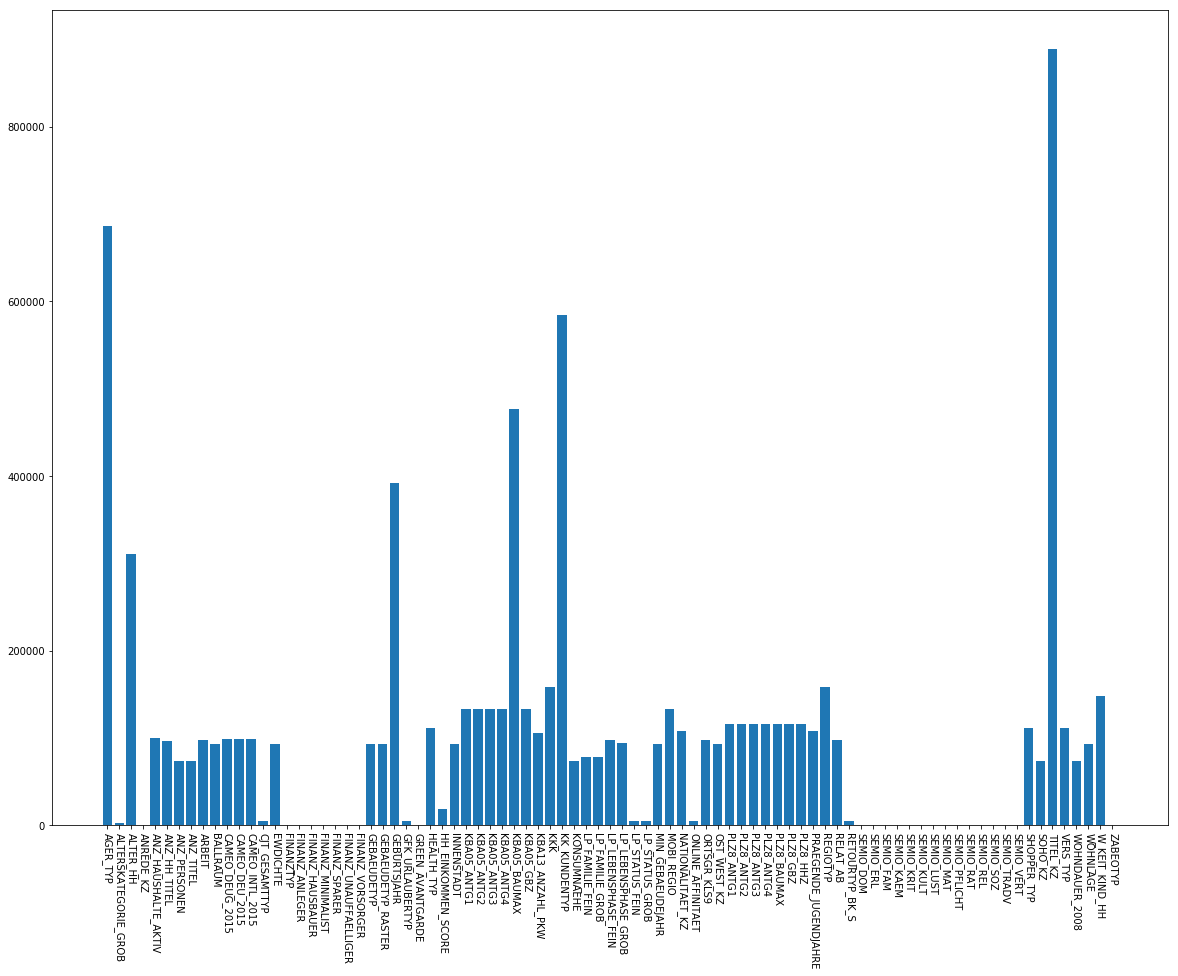

In [6]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

cols_na = azdias.isnull().sum()

plt.figure(figsize=(20,15))
plt.xticks(rotation=-90)
plt.bar(azdias.columns, cols_na.values.tolist())

print('no of columns with missing data \r {}'.format(cols_na))


In [7]:
# Investigate patterns in the amount of missing data in each column.
# binning no of columns based on %age of missing data.
percent_na = (cols_na/azdias.shape[0])*100
outlier_cols = []
for index,val in percent_na.sort_values(ascending=False).iteritems():
    
    # cut off is >30%
    if(val>=30.0):
        person_data = feat_info[feat_info.attribute == index]
        print("column name is {0}, column type is {1} and percentage of missing values is {2}".format(index,person_data['information_level'] ,val))
        outlier_cols.append(index)
    
cols = pd.DataFrame()
cols = pd.cut(percent_na, [0,10,20,30,40,50,60,70,80,90,100], include_lowest=True)
print(cols.sort_values(ascending=False))


column name is TITEL_KZ, column type is 40    person
Name: information_level, dtype: object and percentage of missing values is 99.75763587258379
column name is AGER_TYP, column type is 0    person
Name: information_level, dtype: object and percentage of missing values is 76.95543529607134
column name is KK_KUNDENTYP, column type is 47    household
Name: information_level, dtype: object and percentage of missing values is 65.59674873011295
column name is KBA05_BAUMAX, column type is 64    microcell_rr3
Name: information_level, dtype: object and percentage of missing values is 53.468668265222654
column name is GEBURTSJAHR, column type is 11    person
Name: information_level, dtype: object and percentage of missing values is 44.02028228688507
column name is ALTER_HH, column type is 43    household
Name: information_level, dtype: object and percentage of missing values is 34.81369940789097
TITEL_KZ                  (90.0, 100.0]
AGER_TYP                   (70.0, 80.0]
KK_KUNDENTYP        

In [8]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
print(len(outlier_cols))
azdias_cols = azdias.drop(axis = 'columns',columns = outlier_cols)
print(azdias_cols.shape)


6
(891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

The data as per the document is divided in to :
 1. Person-level features (most important)
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level features
 7. RR1 neighborhood features
 8. PLZ8 macro-cell features
 9. Community-level features
 
 columns related to personal data have the highest missing data. 3 columns in personal related columns have data more that 45% missing. 
 columns related to house hold data is have missing. 2 columns in house hold data in 40% - 50% range.
 
 The removal criteria for removing columns was missing values > 30%. 6 Columns were removed from the data sets:
 1. TITEL_KZ - 99.75% missing values
 2. AGER_TYP - 77% missing values
 3. KK_KUNDENTYP  - 65.5 % missing values
 4. KBA05_BAUMAX - 53.4% missing values            
 5. GEBURTSJAHR = 44% missing values               
 6. ALTER_HH - 34% missing values
 
 Total no. of columns have been reduced from 85 to 79
 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [9]:
# How much data is missing in each row of the dataset?
row_count = sum(azdias_cols.isnull().any(axis=1))

print("the null count for rows is {0}".format(row_count))
print("percentage of rows with null data {}%".format((row_count*100)/azdias_cols.shape[0]))



the null count for rows is 268012
percentage of rows with null data 30.07245116531141%


In [10]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 20 # rows with 25% missing data or 20 columns having empty vals.
row_index = azdias_cols.isnull().sum(axis=1)>20

#generating subsets with more than 20 emtpy columns
row_zip_20 = row_index[row_index == True]
print("no. of rows with more that 20 columns empty {}".format(row_zip_20.shape[0]))
row_index_20 = list(zip(*row_zip_20.items()))[0]
azdias_abv_20 = azdias_cols.iloc[list(row_index_20),:]
print(azdias_abv_20.shape)

#generating subsets with less than or equal to 20 columns
row_zip_good = row_index[row_index == False]
print("no. of rows with less that 20 columns empty {}".format(row_zip_good.shape[0]))
row_index_good = list(zip(*row_zip_good.items()))[0]
azdias_bel_20 = azdias_cols.iloc[list(row_index_good),:]
print(azdias_bel_20.shape)



no. of rows with more that 20 columns empty 93795
(93795, 79)
no. of rows with less that 20 columns empty 797426
(797426, 79)


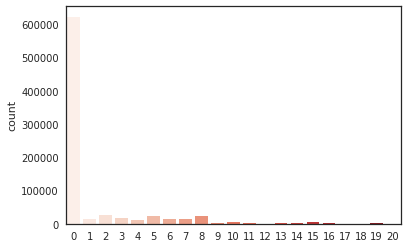

In [11]:
sns.set(style="white")
sns.countplot(azdias_bel_20.isnull().transpose().sum(),palette="Reds")

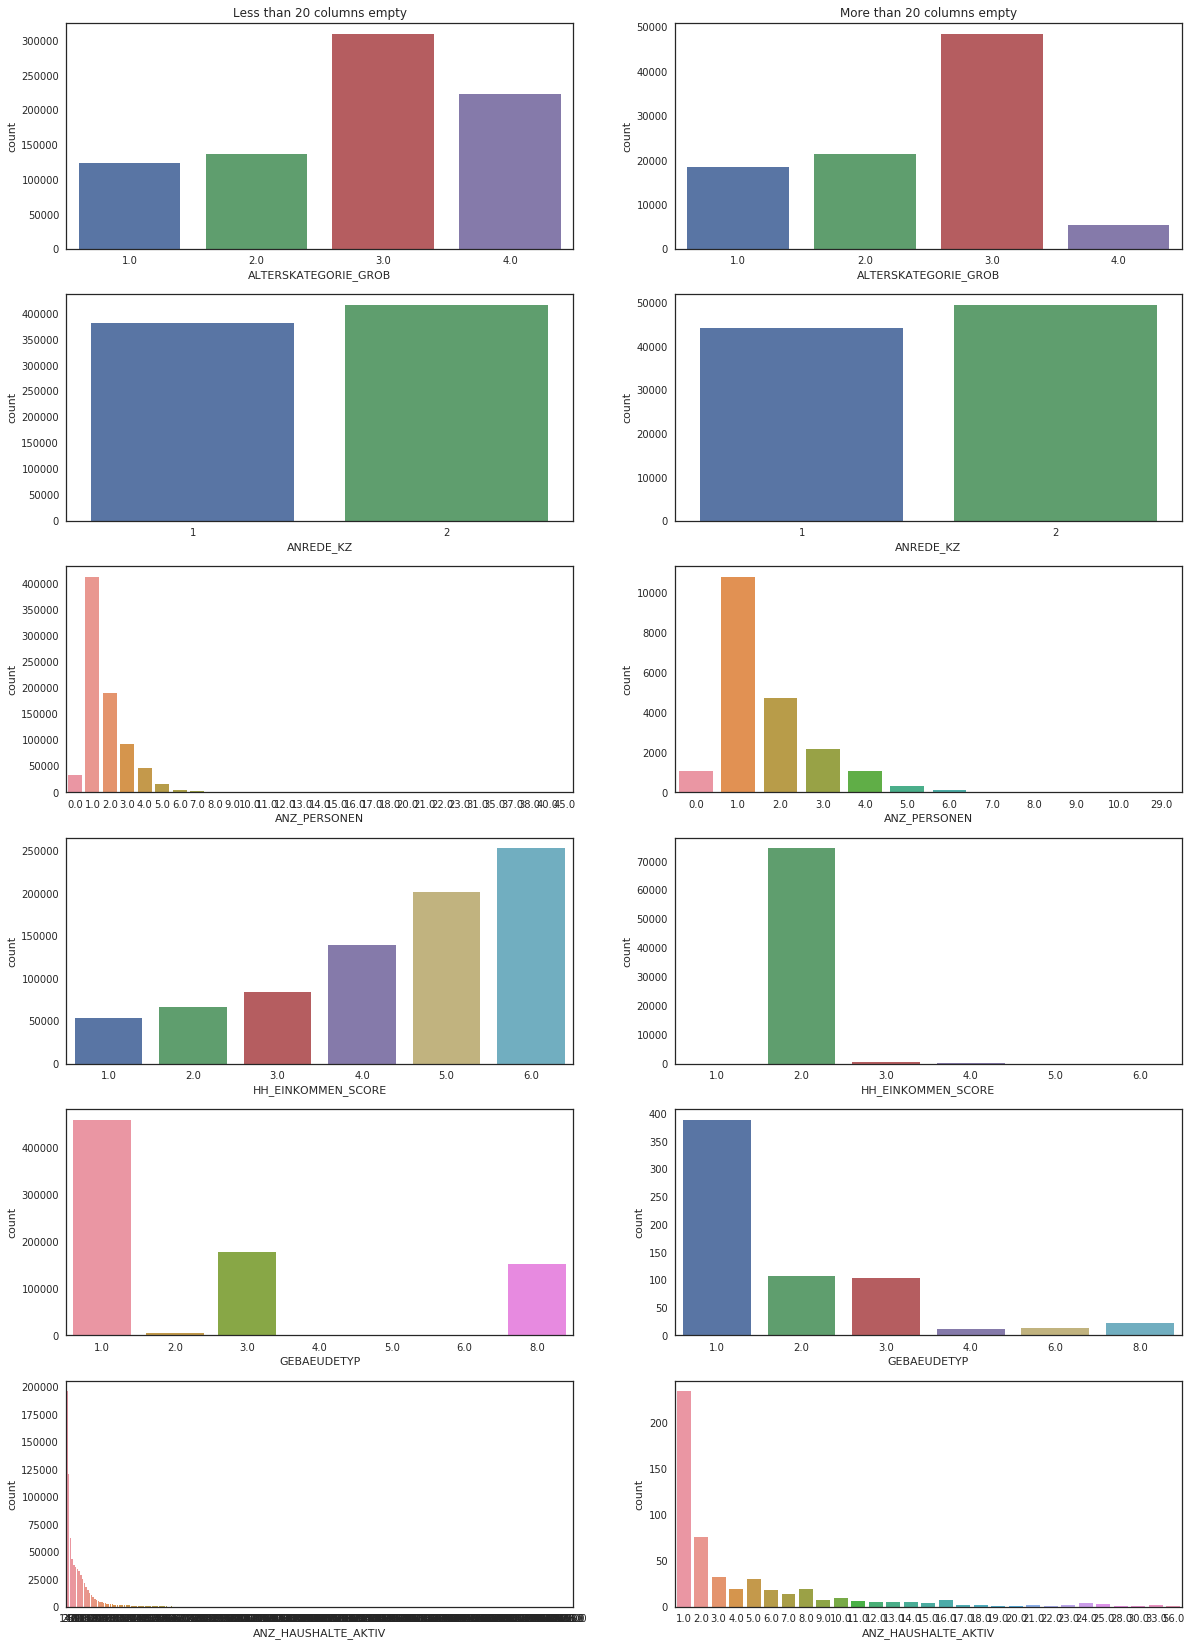

In [12]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.


#getting 2 columns from personal, 2 from house hold, 2 building level
#preparing column names
personal_data_col = feat_info[(feat_info.information_level == 'person')]
household_data_col = feat_info[(feat_info.information_level == 'household')]
buiding_data_col = feat_info[(feat_info.information_level == 'building')]
#print(personal_data_col.shape[0], household_data_col.shape[0],buiding_data_col.shape[0])

#print(personal_data_col.head())
#print(household_data_col.head())
#print(buiding_data_col.head())

#columns ALTERSKATEGORIE_GROB, ANREDE_KZ,ANZ_PERSONEN,HH_EINKOMMEN_SCORE,GEBAEUDETYP,ANZ_HAUSHALTE_AKTIV
col_arr = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ','ANZ_PERSONEN','HH_EINKOMMEN_SCORE','GEBAEUDETYP','ANZ_HAUSHALTE_AKTIV']
#print(azdias.loc[:,['ALTERSKATEGORIE_GROB', 'ANREDE_KZ','ANZ_PERSONEN','HH_EINKOMMEN_SCORE','GEBAEUDETYP','ANZ_HAUSHALTE_AKTIV']])

fig, axs = plt.subplots(6, 2,figsize=(20,20))
iter = 0
axs[0,0].set_title('Less than 20 columns empty')
axs[0,1].set_title('More than 20 columns empty')
for colname in col_arr:
    sns.countplot(azdias_bel_20.loc[:,colname], ax= axs[iter, 0])
    sns.countplot(azdias_abv_20.loc[:,colname], ax=axs[iter, 1])
    plt.subplots_adjust(bottom=0.1, top=1.2)
    iter = iter+1



#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

After choosing 2 columns in different categories, below are my observations:
Rows with less than 20 columns empty have more values filled than rows that have more than 20 columns empty.
Both columns have almost the same distribution of values but on a vastly different scale.
THe chart in section 68 shows the amount of rows with no or atleast 20 missing values. One can see that the chart rapidly decreases as it moves to the right. 

Row more than 20 emtpy cols are only 10% of data and can be discarded. Rows with less than 20 columns emtpy will used further. 



### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [13]:
# How many features are there of each data type?

print("types of data {}".format(pd.unique(feat_info['type'])))

feat_cols = feat_info[(feat_info.type == 'categorical')|(feat_info.type == 'mixed')]['attribute']
data_cols = azdias_bel_20.columns
reqd_cols = np.intersect1d(feat_cols, data_cols).astype(str)

print(len(reqd_cols), len(data_cols), len(feat_cols))
azdias_bel_20.loc[:,reqd_cols].head(15)


types of data ['categorical' 'ordinal' 'numeric' 'mixed' 'interval']
24 79 28


,ANREDE_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,FINANZTYP,GEBAEUDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,...,LP_STATUS_GROB,NATIONALITAET_KZ,OST_WEST_KZ,PLZ8_BAUMAX,PRAEGENDE_JUGENDJAHRE,SHOPPER_TYP,SOHO_KZ,VERS_TYP,WOHNLAGE,ZABEOTYP
1,2,8,8A,51,5.0,1,8.0,10.0,0,5.0,...,1.0,1.0,W,1.0,14.0,3.0,1.0,2.0,4.0,5
2,2,4,4C,24,3.0,1,1.0,10.0,1,1.0,...,2.0,1.0,W,1.0,15.0,2.0,0.0,1.0,2.0,5
3,2,2,2A,12,2.0,6,1.0,1.0,0,NaN,...,4.0,1.0,W,1.0,8.0,1.0,0.0,1.0,7.0,3
4,1,6,6B,43,5.0,5,1.0,5.0,0,10.0,...,2.0,1.0,W,2.0,8.0,2.0,0.0,2.0,3.0,4
5,2,8,8C,54,2.0,2,1.0,1.0,0,1.0,...,2.0,1.0,W,1.0,3.0,0.0,0.0,2.0,7.0,4
6,2,4,4A,22,5.0,4,1.0,12.0,0,1.0,...,1.0,1.0,W,1.0,10.0,1.0,0.0,1.0,5.0,4
7,1,2,2D,14,3.0,5,8.0,9.0,0,1.0,...,1.0,1.0,W,1.0,8.0,0.0,0.0,1.0,1.0,1
8,1,1,1A,13,3.0,6,3.0,3.0,1,1.0,...,5.0,1.0,W,1.0,11.0,3.0,0.0,2.0,1.0,6
9,2,1,1E,15,4.0,1,3.0,12.0,1,1.0,...,2.0,1.0,W,1.0,15.0,3.0,0.0,2.0,7.0,4
10,2,9,9D,51,1.0,6,1.0,8.0,0,1.0,...,1.0,1.0,W,2.0,3.0,2.0,0.0,2.0,5.0,3


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [14]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_cols = feat_info[(feat_info.type == 'categorical')]['attribute']
data_cols = azdias_bel_20.columns
reqd_cols = np.intersect1d(feat_cols, data_cols).astype(str)

print(len(reqd_cols), len(data_cols), len(feat_cols))
azdias_bel_20.loc[:,reqd_cols].head(15)

unique_per_col = azdias_bel_20.loc[:,reqd_cols].nunique()
print(unique_per_col.sort_values())
 

18 79 21
ANREDE_KZ            2
SOHO_KZ              2
OST_WEST_KZ          2
GREEN_AVANTGARDE     2
VERS_TYP             2
NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_STATUS_GROB       5
LP_FAMILIE_GROB      5
ZABEOTYP             6
FINANZTYP            6
CJT_GESAMTTYP        6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEU_2015      44
dtype: int64


In [15]:
print(azdias_bel_20.shape)
#dropping 'GEBAEUDETYP' as no of unique values in gen pop and customer data is different. This causes no. of columns 
#in getdummies  to be different. 
col_rem = ['CAMEO_DEU_2015','GEBAEUDETYP']
azdias_bel_20_v2 = azdias_bel_20.drop(axis = 'columns',columns = col_rem)
print(azdias_bel_20_v2.shape)


(797426, 79)
(797426, 77)


Note: As per the note we can remove selected categorical values. Therefore, GEBAEUDETYP has been removed. The reason is that this column has 7 non-unique values in general population data and 6 non-unique values in customer data. The no. of columns will differ when using this same cleaning logic in clean_data function. 

In [16]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_bel_20_v2['OST_WEST_KZ'] = np.where((azdias_bel_20_v2['OST_WEST_KZ'] == 'O') , 1, 0)

In [17]:
#need to convert categorical data greater than 3
feat_cols = feat_info[(feat_info.type == 'categorical')]['attribute']
data_cols = azdias_bel_20_v2.columns
reqd_cols = np.intersect1d(feat_cols, data_cols).astype(str)
unique_per_col = azdias_bel_20_v2.loc[:,reqd_cols].nunique()
print(len(reqd_cols), len(data_cols), len(feat_cols))
#getting columns with more than 2 categorical vals
col_grt_2 = unique_per_col[unique_per_col > 2]
col_names_grt_2 = list(zip(*col_grt_2.items()))[0]
print(col_names_grt_2)

azdias_bel_20_v3 =  pd.get_dummies(azdias_bel_20_v2, prefix=list(col_names_grt_2), columns=list(col_names_grt_2))
print(azdias_bel_20_v3.shape)
print(azdias_bel_20_v3.head())


16 77 21
('CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP')
(797426, 143)
   ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0          2                  1              5   
2                   3.0          2                  1              4   
3                   4.0          2                  4              2   
4                   3.0          1                  4              3   
5                   1.0          2                  3              1   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1                 2               5                      4                 5   
2                 1               2                      3                 5   
3                 5               2                      1                 2   
4                 4               

#### Discussion 1.2.1: Re-Encode Categorical Features

There are 18 columns with categorical features

CAMEO_DEU_2015 has 44 categories. For a feature that is part of 'RR4 micro-cell' category is not an important feature. 
THis column talks about the wealth of the person. This is a redundant column as LP_LEBENSPHASE_FEIN already talks about the person's financial status. 

The one variable with non-numerical value has been converted to 0 or 1 depending on the values 'W' or 'O'
encoded all columns with categorical vals greater than 2 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [18]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
avantgarde = list()
decade = list()
#mainstream = 0 and avantgarde = 1
dict_PJ = {
    1.0: (0,40),
    2.0: (1,40),
    3.0: (0,50),
    4.0: (1,50),
    5.0: (0,60),
    6.0: (1,60),
    7.0: (1,60),
    8.0: (0,70),
    9.0: (1,70),
    10.0: (0,80),
    11.0: (1,80),
    12.0: (0,80),
    13.0: (1,80),
    14.0:(0,90),
    15.0:(1,90)
}

for val in azdias_bel_20_v3.loc[:,"PRAEGENDE_JUGENDJAHRE"]:
    if(val>0):
        temp_set = dict_PJ.get(val)
        decade.append(temp_set[1])
        avantgarde.append(temp_set[0])
    else:
        decade.append(np.nan)
        avantgarde.append(np.nan)

azdias_bel_20_v3["PJ_Decade"] = decade
azdias_bel_20_v3['PJ_Mainstream'] = avantgarde
print(azdias_bel_20_v3.shape)
col_rem = ['PRAEGENDE_JUGENDJAHRE']
azdias_bel_20_v3 = azdias_bel_20_v3.drop(axis = 'columns',columns = col_rem)
print(azdias_bel_20_v3.shape)

(797426, 145)
(797426, 144)


In [19]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
import math
wealth = list()
life_stage = list()

for val in azdias_bel_20_v3.loc[:,"CAMEO_INTL_2015"].astype('float'):
    if((val>=11.0) and not(math.isnan(val))):
        temp_w = val // 10
        temp_ls = val % 10
        wealth.append(temp_w)
        life_stage.append(temp_ls)
    else:
        wealth.append(np.nan)
        life_stage.append(np.nan)

azdias_bel_20_v3["CI_Wealth"] = wealth
azdias_bel_20_v3['CI_lifestage'] = life_stage
print(azdias_bel_20_v3.shape)

#print(azdias_bel_20_v3["CI_Wealth"].head())
#print(azdias_bel_20_v3["CI_lifestage"].head())
col_rem = ['CAMEO_INTL_2015']
azdias_bel_20_v3 = azdias_bel_20_v3.drop(axis = 'columns',columns = col_rem)
print(azdias_bel_20_v3.shape)

(797426, 146)
(797426, 145)


In [20]:
#looking at the rest of the mixed value features
feat_cols = feat_info[(feat_info.type == 'mixed')]['attribute']
data_cols = azdias_bel_20_v3.columns
reqd_cols = np.intersect1d(feat_cols, data_cols).astype(str)
#print(azdias_bel_20_v3[reqd_cols].head())
unique_per_col = azdias_bel_20_v3.loc[:,reqd_cols].nunique()
print(unique_per_col)

azdias_bel_20_v3 = azdias_bel_20_v3.drop(axis = 'columns',columns = reqd_cols)
print(azdias_bel_20_v3.shape)




LP_LEBENSPHASE_FEIN    40
LP_LEBENSPHASE_GROB    12
PLZ8_BAUMAX             5
WOHNLAGE                8
dtype: int64
(797426, 141)


#### Discussion 1.2.2: Engineer Mixed-Type Features

created 2 extra columns each for CAMEO_INTL_2015 and PRAEGENDE_JUGENDJAHRE. 
Deleted columns CAMEO_INTL_2015 and PRAEGENDE_JUGENDJAHRE
Removed all other mixed types as there was no way to break them in to categorical data. 


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [21]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [22]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [23]:
def clean_data(azdias):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Load in the feature summary file.
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';', error_bad_lines= False, warn_bad_lines = True)

    #parsing featInfo to replace the missing values
    #columns of interest:missing_or_unknown, attribute 
    for index, feat in feat_info.iterrows():
        attrib_name = feat['attribute']
        m_u_val = feat['missing_or_unknown']
        #remove brackets and then split
        m_u_val = m_u_val.replace('[','')
        m_u_val = m_u_val.replace(']','')
        m_u_arr = m_u_val.split(',')
        #print(m_u_arr)
        #the loop is reqd to take in to account value X
        m_u_arr_v2 = []

        for iter in m_u_arr:
            #print(iter)
            try:
                flt = float(iter) 
                m_u_arr_v2.append(int(flt))
            except ValueError:
                m_u_arr_v2.append(iter)
        #print(m_u_arr_v2)

        azdias[attrib_name].replace(m_u_arr_v2, np.nan,inplace = True)

    
    # Investigate patterns in the amount of missing data in each column.
    # binning no of columns based on %age of missing data.
    cols_na = azdias.isnull().sum()
    percent_na = (cols_na/azdias.shape[0])*100
    '''
    outlier_cols = []
    for index,val in percent_na.sort_values(ascending=False).iteritems():

        # cut off is >30%
        if(val>=30.0):
            person_data = feat_info[feat_info.attribute == index]
            #print("column name is {0}, column type is {1} and percentage of missing values is {2}".format(index,person_data['information_level'] ,val))
            outlier_cols.append(index)
    print('no of outlier cols {}'.format(len(outlier_cols)))
    '''
    outlier_cols = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP',  'KBA05_BAUMAX',  'GEBURTSJAHR', 'ALTER_HH']
    azdias_cols = azdias.drop(axis = 'columns',columns = outlier_cols)
    print("shape after 30 percent cut is {}".format(azdias_cols.shape))

    # Write code to divide the data into two subsets based on the number of missing
    # values in each row.
    threshold = 20 # rows with 25% missing data or 20 columns having empty vals.
    row_index = azdias_cols.isnull().sum(axis=1)>20

    #generating subsets with more than 20 emtpy columns
    row_zip_20 = row_index[row_index == True]
    #print("no. of rows with more that 20 columns empty {}".format(row_zip_20.shape[0]))
    row_index_20 = list(zip(*row_zip_20.items()))[0]
    azdias_abv_20 = azdias_cols.iloc[list(row_index_20),:]
    print(azdias_abv_20.shape)

    #generating subsets with less than or equal to 20 columns
    row_zip_good = row_index[row_index == False]
    print("no. of rows with less that 20 columns empty {}".format(row_zip_good.shape[0]))
    row_index_good = list(zip(*row_zip_good.items()))[0]
    azdias_bel_20 = azdias_cols.iloc[list(row_index_good),:]
    print(azdias_bel_20.shape)

    col_rem = ['CAMEO_DEU_2015','GEBAEUDETYP']
    azdias_bel_20_v2 = azdias_bel_20.drop(axis = 'columns',columns = col_rem)
    print('column cameo_deu_2015 removed {}'.format(azdias_bel_20_v2.shape))

    # Re-encode categorical variable(s) to be kept in the analysis.
    azdias_bel_20_v2['OST_WEST_KZ'] = np.where((azdias_bel_20_v2['OST_WEST_KZ'] == 'O') , 1, 0)

    #need to convert categorical data greater than 3
    feat_cols = feat_info[(feat_info.type == 'categorical')]['attribute']
    data_cols = azdias_bel_20_v2.columns
    reqd_cols = np.intersect1d(feat_cols, data_cols).astype(str)
    unique_per_col = azdias_bel_20_v2.loc[:,reqd_cols].nunique()
    print('unique vals per col {}'.format(unique_per_col.sort_values()))
    
    #getting columns with more than 2 categorical vals
    col_grt_2 = unique_per_col[unique_per_col > 2]
    col_names_grt_2 = list(zip(*col_grt_2.items()))[0]
    print(col_names_grt_2)

    azdias_bel_20_v3 =  pd.get_dummies(azdias_bel_20_v2, prefix=list(col_names_grt_2), columns=list(col_names_grt_2))
    print('Shape after converting categorical data greater than 2 {}'.format(azdias_bel_20_v3.shape))
    
    filter_col = [col for col in azdias_bel_20_v3 if col.startswith('GEBAEUDETYP')]
    print(filter_col)
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    avantgarde = list()
    decade = list()
    #mainstream = 0 and avantgarde = 1
    dict_PJ = {
        1.0: (0,40),
        2.0: (1,40),
        3.0: (0,50),
        4.0: (1,50),
        5.0: (0,60),
        6.0: (1,60),
        7.0: (1,60),
        8.0: (0,70),
        9.0: (1,70),
        10.0: (0,80),
        11.0: (1,80),
        12.0: (0,80),
        13.0: (1,80),
        14.0:(0,90),
        15.0:(1,90)
    }

    for val in azdias_bel_20_v3.loc[:,"PRAEGENDE_JUGENDJAHRE"]:
        if(val>0):
            temp_set = dict_PJ.get(val)
            decade.append(temp_set[1])
            avantgarde.append(temp_set[0])
        else:
            decade.append(np.nan)
            avantgarde.append(np.nan)

    azdias_bel_20_v3["PJ_Decade"] = decade
    azdias_bel_20_v3['PJ_Mainstream'] = avantgarde
    print(azdias_bel_20_v3.shape)
    col_rem = ['PRAEGENDE_JUGENDJAHRE']
    azdias_bel_20_v3 = azdias_bel_20_v3.drop(axis = 'columns',columns = col_rem)
    print(azdias_bel_20_v3.shape)

    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    import math
    wealth = list()
    life_stage = list()

    for val in azdias_bel_20_v3.loc[:,"CAMEO_INTL_2015"].astype('float'):
        if((val>=11.0) and not(math.isnan(val))):
            temp_w = val // 10
            temp_ls = val % 10
            wealth.append(temp_w)
            life_stage.append(temp_ls)
        else:
            wealth.append(np.nan)
            life_stage.append(np.nan)

    azdias_bel_20_v3["CI_Wealth"] = wealth
    azdias_bel_20_v3['CI_lifestage'] = life_stage
    print(azdias_bel_20_v3.shape)

    #print(azdias_bel_20_v3["CI_Wealth"].head())
    #print(azdias_bel_20_v3["CI_lifestage"].head())
    col_rem = ['CAMEO_INTL_2015']
    azdias_bel_20_v3 = azdias_bel_20_v3.drop(axis = 'columns',columns = col_rem)
    print(azdias_bel_20_v3.shape)

    #looking at the rest of the mixed value features
    feat_cols = feat_info[(feat_info.type == 'mixed')]['attribute']
    data_cols = azdias_bel_20_v3.columns
    reqd_cols = np.intersect1d(feat_cols, data_cols).astype(str)
    #print(azdias_bel_20_v3[reqd_cols].head())
    unique_per_col = azdias_bel_20_v3.loc[:,reqd_cols].nunique()
    print(unique_per_col)

    azdias_bel_20_v3 = azdias_bel_20_v3.drop(axis = 'columns',columns = reqd_cols)
    print(azdias_bel_20_v3.shape)
    
    return azdias_bel_20_v3
    
    
ans = clean_data(customers)    
print(ans.shape)

shape after 30 percent cut is (191652, 79)
(50012, 79)
no. of rows with less that 20 columns empty 141640
(141640, 79)
column cameo_deu_2015 removed (141640, 77)
unique vals per col ANREDE_KZ            2
GREEN_AVANTGARDE     2
OST_WEST_KZ          2
SOHO_KZ              2
VERS_TYP             2
NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_FAMILIE_GROB      5
LP_STATUS_GROB       5
CJT_GESAMTTYP        6
FINANZTYP            6
ZABEOTYP             6
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
dtype: int64
('CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP')
Shape after converting categorical data greater than 2 (141640, 143)
['GEBAEUDETYP_RASTER']
(141640, 145)
(141640, 144)
(141640, 146)
(141640, 145)
LP_LEBENSPHASE_FEIN    40
LP_LEBENSPHASE_GROB    12
PLZ8_BAUMAX             5
WOHNLAGE             

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [24]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imp = Imputer()

azdias_bel_20_v4 = pd.DataFrame(imp.fit_transform(azdias_bel_20_v3), columns = azdias_bel_20_v3.columns)


In [25]:
# Apply feature scaling to the general population demographics data.
ss = StandardScaler()

azdias_bel_20_v4 = pd.DataFrame(ss.fit_transform(azdias_bel_20_v4), columns = azdias_bel_20_v4.columns)
print(azdias_bel_20_v4.shape)

(797426, 141)


### Discussion 2.1: Apply Feature Scaling

Used imputer to replace all empty values. Used the default option of mean for replacement. 
Used Standard scaler to standardize all values. Used default options.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [26]:
# Apply PCA to the data.
pca = PCA()
azdias_red = pd.DataFrame(pca.fit_transform(azdias_bel_20_v4), columns = azdias_bel_20_v4.columns)


In [27]:
# Investigate the variance accounted for by each principal component.

# PCA components
components = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_red.keys())

# PCA explained variance
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios.index = azdias_red.keys()
print(variance_ratios)


                       Explained Variance
ALTERSKATEGORIE_GROB               0.1022
ANREDE_KZ                          0.0779
FINANZ_MINIMALIST                  0.0483
FINANZ_SPARER                      0.0360
FINANZ_VORSORGER                   0.0273
FINANZ_ANLEGER                     0.0210
FINANZ_UNAUFFAELLIGER              0.0177
FINANZ_HAUSBAUER                   0.0174
GREEN_AVANTGARDE                   0.0170
HEALTH_TYP                         0.0166
RETOURTYP_BK_S                     0.0157
SEMIO_SOZ                          0.0147
SEMIO_FAM                          0.0145
SEMIO_REL                          0.0143
SEMIO_MAT                          0.0135
SEMIO_VERT                         0.0127
SEMIO_LUST                         0.0120
SEMIO_ERL                          0.0114
SEMIO_KULT                         0.0110
SEMIO_RAT                          0.0107
SEMIO_KRIT                         0.0104
SEMIO_DOM                          0.0100
SEMIO_KAEM                        

In [28]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Dimension indexing
for comp in range(20, azdias_bel_20_v4.shape[1]):
    pca = PCA(n_components = comp)
    azdias_red = pd.DataFrame(pca.fit_transform(azdias_bel_20_v4))
    # PCA components
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    components = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_bel_20_v4.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    #print(variance_ratios['Explained Variance'].sum())
    if variance_ratios['Explained Variance'].sum() > 0.75:
        print('no. of features to retain {0} and sum of explained variance is {1}'.format(comp, variance_ratios['Explained Variance'].sum()))
        break
    #print(comp)




no. of features to retain 50 and sum of explained variance is 0.7573000000000001


In [29]:
pca = PCA(n_components = comp)
azdias_red = pd.DataFrame(pca.fit_transform(azdias_bel_20_v4))


### Discussion 2.2: Perform Dimensionality Reduction

Applied PCA with default values. 
Applied PCA to achieve explained variance >=75. Tried 85 but no.of columns were a large no which almost nullified dimensionality reduction. 


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [30]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_results(full_dataset, pca):
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

df_azdias_vr = pca_results(azdias_bel_20_v4,pca)
#print(df_azdias_vr.iloc[0,0:].sort_values(ascending=False))
print("Top +ve features of 1st dimensions are:\n {}".format(df_azdias_vr.iloc[0,:].sort_values(ascending=False).head()))
print("Top -ve features of 1st dimensions are:\n {}".format(df_azdias_vr.iloc[0,:].sort_values(ascending=False).tail()))


Top +ve features of 1st dimensions are:
 LP_STATUS_GROB_1.0    0.2023
HH_EINKOMMEN_SCORE    0.1895
PLZ8_ANTG3            0.1840
CI_Wealth             0.1835
PLZ8_ANTG4            0.1777
Name: Dimension 1, dtype: float64
Top -ve features of 1st dimensions are:
 PLZ8_ANTG1          -0.1840
KBA05_GBZ           -0.1843
KBA05_ANTG1         -0.1944
FINANZ_MINIMALIST   -0.2035
MOBI_REGIO          -0.2072
Name: Dimension 1, dtype: float64


In [31]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
#print(df_azdias_vr.iloc[1,0:].sort_values(ascending=False))

print("Top +ve features of 2nd dimensions are:\n {}".format(df_azdias_vr.iloc[1,:].sort_values(ascending=False).head()))
print("Top -ve features of 2nd dimensions are:\n {}".format(df_azdias_vr.iloc[1,:].sort_values(ascending=False).tail()))


Top +ve features of 2nd dimensions are:
 ALTERSKATEGORIE_GROB    0.2281
FINANZ_VORSORGER        0.2143
ZABEOTYP_3              0.2006
SEMIO_ERL               0.1789
SEMIO_LUST              0.1602
Name: Dimension 2, dtype: float64
Top -ve features of 2nd dimensions are:
 SEMIO_TRADV             -0.2047
SEMIO_REL               -0.2099
FINANZ_UNAUFFAELLIGER   -0.2123
FINANZ_SPARER           -0.2191
PJ_Decade               -0.2333
Name: Dimension 2, dtype: float64


In [32]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
#print(df_azdias_vr.iloc[2,:].sort_values(ascending=False))
print("Top +ve features of 3rd dimensions are:\n {}".format(df_azdias_vr.iloc[2,:].sort_values(ascending=False).head()))
print("Top -ve features of 3rd dimensions are:\n {}".format(df_azdias_vr.iloc[2,:].sort_values(ascending=False).tail()))


Top +ve features of 3rd dimensions are:
 SEMIO_VERT     0.3203
SEMIO_FAM      0.2626
SEMIO_SOZ      0.2585
SEMIO_KULT     0.2536
FINANZTYP_5    0.1347
Name: Dimension 3, dtype: float64
Top -ve features of 3rd dimensions are:
 SEMIO_ERL    -0.2083
SEMIO_KRIT   -0.2680
SEMIO_DOM    -0.2869
SEMIO_KAEM   -0.3173
ANREDE_KZ    -0.3476
Name: Dimension 3, dtype: float64


### Discussion 2.3: Interpret Principal Components

Dimension 1 

+ ve contributors
LP_STATUS_GROB1.0 - low-income earners (maps to 1-2 in fine scale)
HH_EINKOMMEN_SCORE - Estimated household net income 
PLZ8_ANTG3 - Number of 6-10 family houses in the PLZ8 region
CI_Wealth - Wealth
PLZ8_ANTG4 - Number of 10+ family houses in the PLZ8 region

-ve contributors
PLZ8_ANTG1          Number of 1-2 family houses in the PLZ8 region
KBA05_GBZ           Number of buildings
KBA05_ANTG1         Number of 1-2 family houses in the microcell
FINANZ_MINIMALIST   low financial interest /financial health
MOBI_REGIO          Movement patterns

##Summary: Low income earner or house hold with lower financial setup living in high density areas  


Dimension 2
 + ve contributors
ALTERSKATEGORIE_GROB    Estimated age based on given name analysis
FINANZ_VORSORGER        well prepared financially
ZABEOTYP_3              energy consumption - well supplied
SEMIO_ERL               event oriented with lowest affinity
SEMIO_LUST              sensual minded

-ve contributors:
SEMIO_TRADV             traditional minded
SEMIO_REL               religious minded
FINANZ_UNAUFFAELLIGER   inconspicuous
FINANZ_SPARER           money saver
PJ_Decade               age of the person

##Summary: Doing well financially, older religious minded, focussed on saving money

Dimension 3
+ve contributors:
SEMIO_VERT     Dreamful
SEMIO_FAM      family minded
SEMIO_SOZ      Socially minded
SEMIO_KULT     cultural minded
FINANZTYP_5    investor

-ve contributors:
SEMIO_ERL    event oriented with lowest affinity
SEMIO_KRIT   critical minded
SEMIO_DOM    Dominant minded
SEMIO_KAEM   combative attitude
ANREDE_KZ    gender

##Summary: Family oriented, well regarded investor who has an alpha personality


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [33]:
# Over a number of different cluster counts...
K = range(1,50)
sqrd_distances = []
scores = []

for km in K:
    kmeans = MiniBatchKMeans(n_clusters=km, random_state = 13)
    kmeans = kmeans.fit(azdias_red)
    sqrd_distances.append(kmeans.inertia_)
    scores.append(kmeans.score(azdias_red))
       

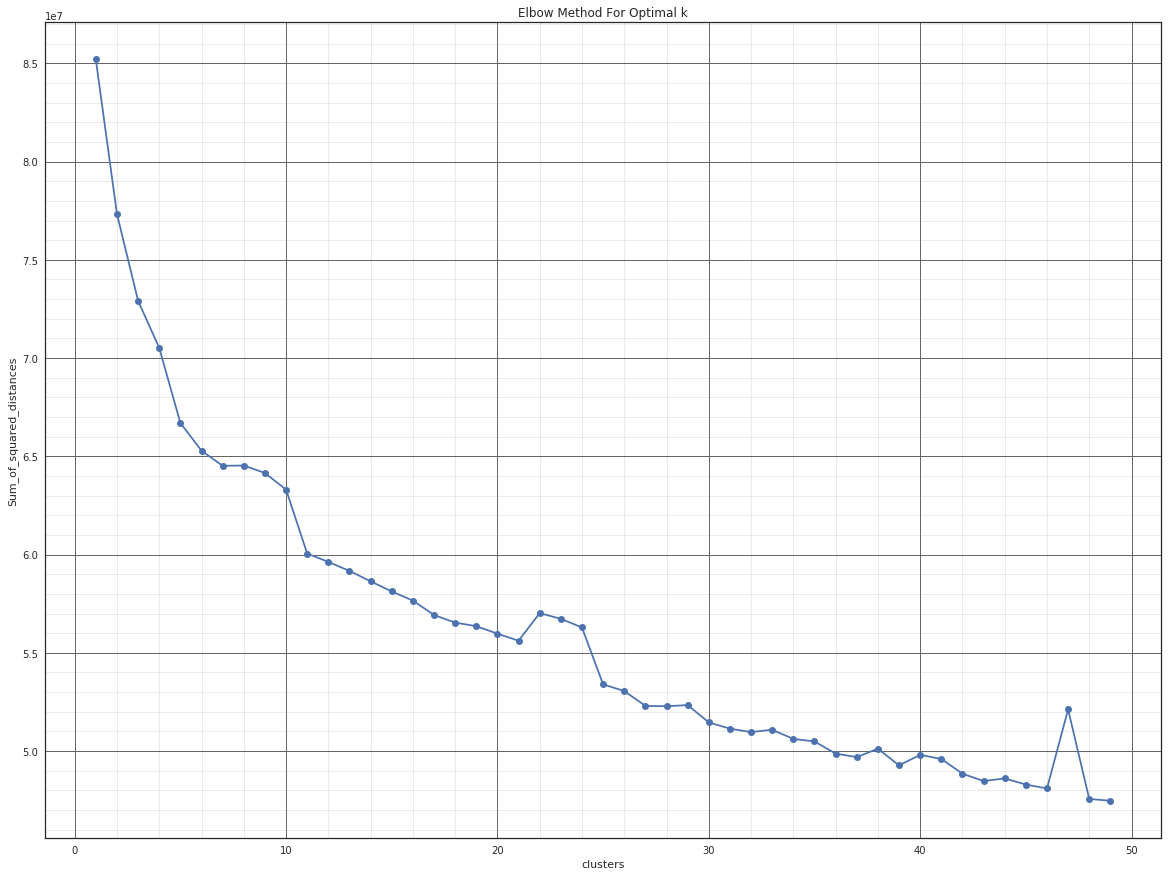

In [34]:
# Investigate the change in within-cluster distance across number of clusters.
#using elbow method to find the best k value
plt.figure(figsize=(20,15))
plt.plot(K, sqrd_distances, '-o')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('clusters')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


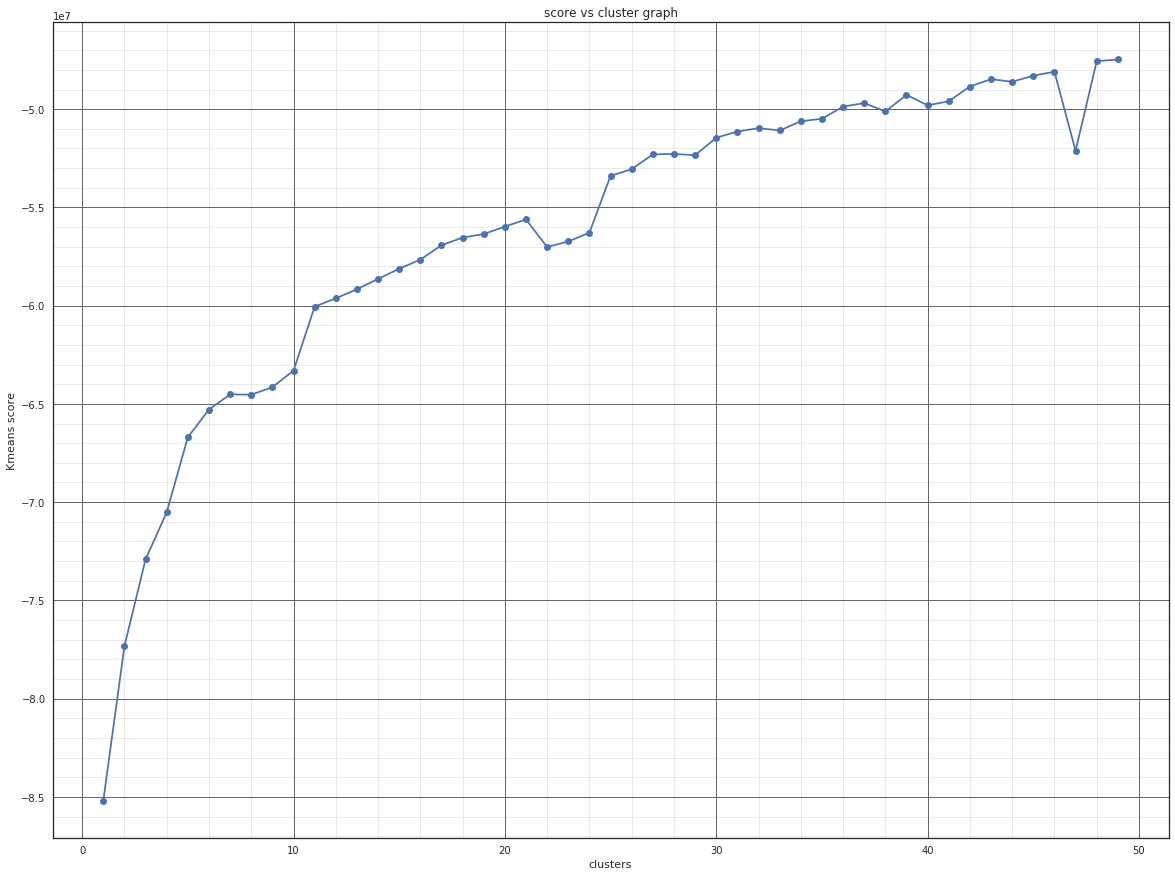

In [35]:
plt.figure(figsize=(20,15))
plt.plot(K, scores, '-o')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('clusters')
plt.ylabel('Kmeans score')
plt.title('score vs cluster graph')
plt.show()

In [36]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = MiniBatchKMeans(n_clusters=20, random_state = 13)
Y_cluster = kmeans.fit_predict(azdias_red)
print(np.unique(Y_cluster))


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Ran MiniBatchKMeans instead of KMeans because the sklearn documentation states that its faster for more than 10k rows (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.score)

Ran kmeans in the range of 1 to 50 clusters and collected inertia and scores values. Plotted them against no of clusters to check out the elbow pattern. At 20 cluster mark the no of clusters vs scores graph seems to slow down. Chose 20 as the number of clusters for kmeans.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [37]:
# Load in the customer demographics data.
customers.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,4.0,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,NaN,4.0,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.0,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1.0,4.0,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,NaN,3.0,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [38]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cln = clean_data(customers)
print("shape of customer data after cleaning {}\n".format(customers_cln.shape))
customers_cln_v2 = pd.DataFrame(imp.fit_transform(customers_cln), columns = customers_cln.columns)

customers_cln_v2 = pd.DataFrame(ss.fit_transform(customers_cln_v2), columns = customers_cln_v2.columns)

print(comp)
customers_red = pd.DataFrame(pca.transform(customers_cln_v2))
print("shape of customer data after PCA {}\n".format(customers_red.shape))
Y_customer_cluster = kmeans.predict(customers_red)
print(np.unique(Y_customer_cluster))


shape after 30 percent cut is (191652, 79)
(50012, 79)
no. of rows with less that 20 columns empty 141640
(141640, 79)
column cameo_deu_2015 removed (141640, 77)
unique vals per col ANREDE_KZ            2
GREEN_AVANTGARDE     2
OST_WEST_KZ          2
SOHO_KZ              2
VERS_TYP             2
NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_FAMILIE_GROB      5
LP_STATUS_GROB       5
CJT_GESAMTTYP        6
FINANZTYP            6
ZABEOTYP             6
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
dtype: int64
('CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP')
Shape after converting categorical data greater than 2 (141640, 143)
['GEBAEUDETYP_RASTER']
(141640, 145)
(141640, 144)
(141640, 146)
(141640, 145)
LP_LEBENSPHASE_FEIN    40
LP_LEBENSPHASE_GROB    12
PLZ8_BAUMAX             5
WOHNLAGE             

Used the same Standard scaler, pca and kmeans object of general population on customer population

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

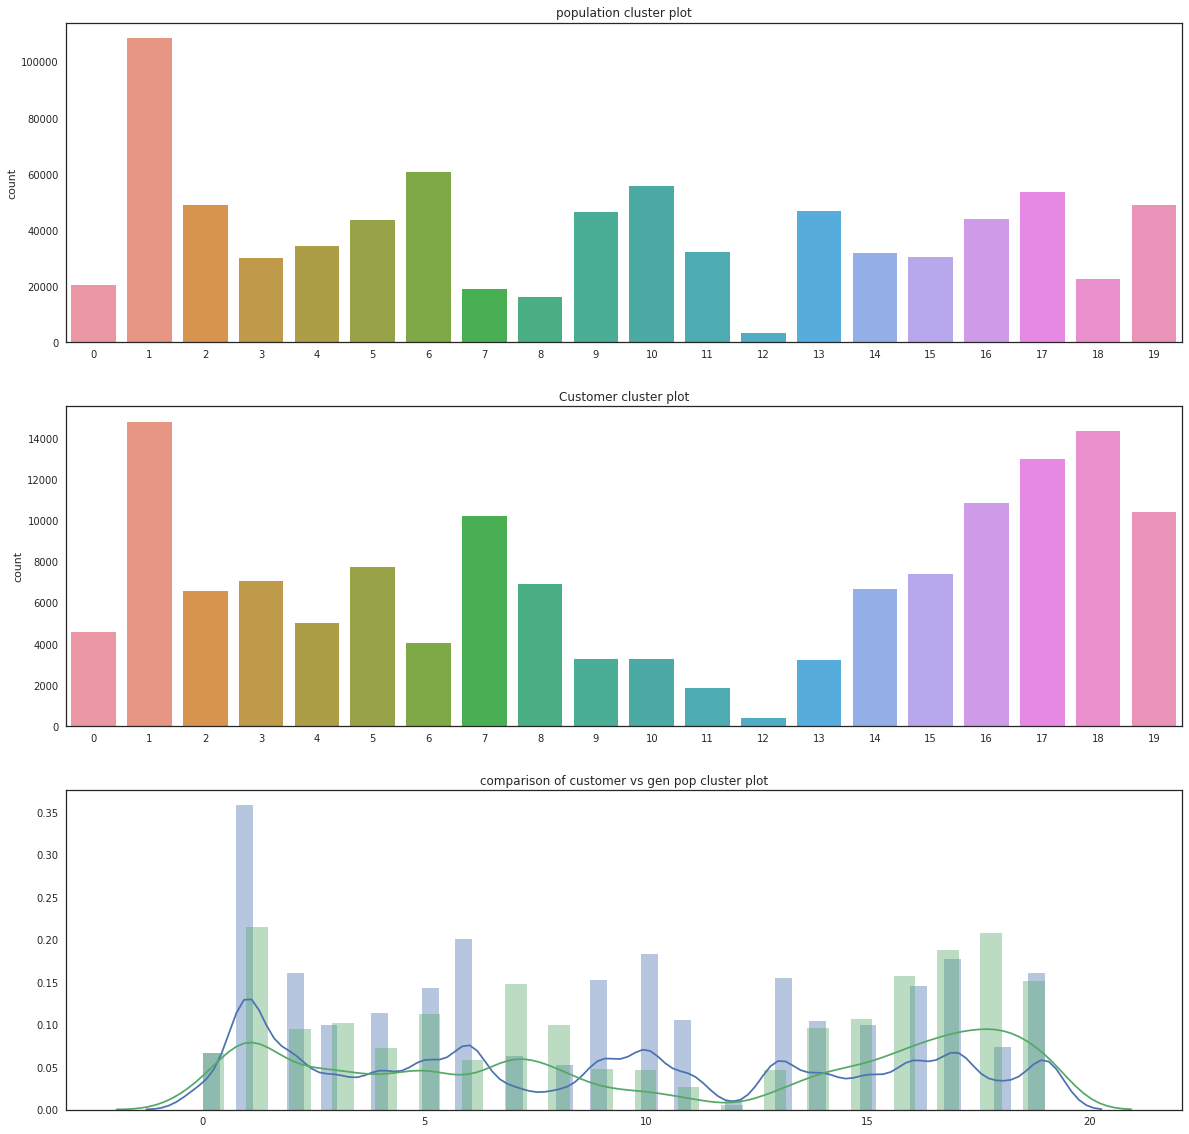

In [39]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, axs = plt.subplots(3, 1,figsize=(20,20))
axs[0].set_title('population cluster plot')
sns.countplot(Y_cluster, ax= axs[0])

axs[1].set_title('Customer cluster plot')
sns.countplot(Y_customer_cluster, ax=axs[1])

axs[2].set_title('comparison of customer vs gen pop cluster plot')
sns.distplot(Y_cluster, ax= axs[2])
sns.distplot(Y_customer_cluster, ax=axs[2])



In [40]:
# What kinds of people are part of a cluster that is overrepresented and underrepresented in the
# customer data compared to the general population?
cust_cluster_grp = pd.DataFrame(Y_customer_cluster, columns=['customer_cluster']).reset_index().groupby('customer_cluster').count()
#print(100*cust_cluster_grp/(len(Y_customer_cluster)))
cust_cluster_grp = 100*cust_cluster_grp/(len(Y_customer_cluster))
#print(cust_cluster_grp)

pop_cluster_grp = pd.DataFrame(Y_cluster, columns=['population_cluster']).reset_index().groupby('population_cluster').count()
#print(100*pop_cluster_grp/(len(Y_cluster)))
pop_cluster_grp = 100*pop_cluster_grp/(len(Y_cluster))
print(pop_cluster_grp.columns)

#creating a dataframe with both results 
pop_cluster_grp['customer_cluster'] = cust_cluster_grp
#print(pop_cluster_grp)

# Storing the difference between two groups for easy viewing
pop_cluster_grp['diff'] = pop_cluster_grp['index'] - pop_cluster_grp['customer_cluster']
print(pop_cluster_grp.sort_values('diff',ascending=False))


Index(['index'], dtype='object')
                        index  customer_cluster      diff
population_cluster                                       
6                    7.636320          2.845241  4.791078
10                   6.981964          2.304434  4.677531
13                   5.885687          2.259249  3.626438
9                    5.820477          2.316436  3.504041
1                   13.615056         10.465970  3.149086
11                   4.021564          1.315306  2.706258
2                    6.125333          4.646992  1.478341
4                    4.329806          3.546315  0.783492
12                   0.427124          0.283818  0.143306
5                    5.451290          5.468088 -0.016799
0                    2.553842          3.234256 -0.680414
14                   3.979680          4.695001 -0.715322
3                    3.775899          4.981644 -1.205745
19                   6.132481          7.359503 -1.227022
15                   3.797092          

In [43]:
#km_cust = pd.DataFrame(pca.inverse_transform(kmeans.cluster_centers_), columns=azdias_bel_20_v4.columns)
km_cust = pd.DataFrame(pca.inverse_transform(kmeans.cluster_centers_), columns=azdias_bel_20_v4.columns)
km_cust_azdias= pd.DataFrame(ss.inverse_transform(km_cust), columns=azdias_bel_20_v4.columns)
print('shape of kmeans cluster centers before pca inverse {}'.format(kmeans.cluster_centers_.shape))
print('shape of kmeans cluster centers after pca inverse {}'.format(km_cust_azdias.shape))

pos_feat = ['LP_STATUS_GROB_1.0' ,'HH_EINKOMMEN_SCORE','PLZ8_ANTG3','CI_Wealth','PLZ8_ANTG4','ALTERSKATEGORIE_GROB','FINANZ_VORSORGER','ZABEOTYP_3','SEMIO_ERL','SEMIO_LUST','SEMIO_VERT','SEMIO_FAM','SEMIO_SOZ','SEMIO_KULT','FINANZTYP_5']
neg_feat = ['PLZ8_ANTG1','KBA05_GBZ','KBA05_ANTG1','FINANZ_MINIMALIST','MOBI_REGIO','SEMIO_TRADV','SEMIO_REL','FINANZ_UNAUFFAELLIGER','FINANZ_SPARER','PJ_Decade','SEMIO_ERL','SEMIO_KRIT','SEMIO_DOM','SEMIO_KAEM','ANREDE_KZ']

km_cust_azdias.loc[:,pos_feat+neg_feat]

shape of kmeans cluster centers before pca inverse (20, 50)
shape of kmeans cluster centers after pca inverse (20, 141)


,LP_STATUS_GROB_1.0,HH_EINKOMMEN_SCORE,PLZ8_ANTG3,CI_Wealth,PLZ8_ANTG4,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,ZABEOTYP_3,SEMIO_ERL,SEMIO_LUST,...,SEMIO_TRADV,SEMIO_REL,FINANZ_UNAUFFAELLIGER,FINANZ_SPARER,PJ_Decade,SEMIO_ERL,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,ANREDE_KZ
0,-0.128304,1.029598,0.992795,1.479818,0.262002,3.347812,4.164239,0.154558,5.634583,5.188655,...,3.376561,2.702518,2.260335,1.516898,65.413803,5.634583,5.009537,5.621786,5.168762,1.745428
1,0.522194,4.527973,2.143738,3.761155,1.094404,3.989317,5.118885,0.817912,5.821333,6.227543,...,1.923139,2.256429,1.105818,0.964394,49.301629,5.821333,4.390790,4.205474,4.124145,1.377372
2,-0.014491,3.988917,1.067753,2.618091,0.266079,4.053467,5.117786,0.893079,6.557604,6.313837,...,1.901409,1.835505,1.174170,0.872460,48.908330,6.557604,5.039205,4.477096,4.397001,1.661128
3,-0.130317,2.147184,1.019588,1.985323,0.306531,3.614427,4.661566,0.341013,4.866969,5.810236,...,2.797974,3.016091,1.706185,1.198967,57.232761,4.866969,3.587884,3.837827,3.186765,1.235424
4,-0.136169,2.213371,0.844724,1.801052,0.202346,3.092158,3.920267,0.183521,4.103783,4.309267,...,3.734210,3.854306,2.606247,1.738780,68.295303,4.103783,4.020444,3.718565,3.223644,1.243736
5,-0.100360,2.601806,0.754737,1.928654,0.130791,4.116307,5.230773,0.783792,6.386398,6.419914,...,1.905501,1.976320,1.214367,0.613430,46.509416,6.386398,4.763871,4.225340,4.200087,1.534146
6,0.484840,4.534824,2.100927,3.737684,1.065209,2.834026,3.704070,0.093625,2.626826,4.557754,...,3.801326,4.897879,2.626740,2.349852,71.340269,2.626826,2.200704,2.536222,1.870279,0.800528
7,-0.117850,1.033798,0.829386,1.414940,0.155046,3.833749,5.101647,0.303336,4.509161,6.044694,...,2.301802,2.869883,1.373755,0.851143,52.868956,4.509161,2.382249,3.036988,2.188899,0.930945
8,-0.121650,0.950908,1.099223,1.571535,0.326654,3.119763,4.011212,0.006429,3.117732,4.924938,...,3.638549,4.277049,2.560417,1.721662,67.299395,3.117732,2.427819,2.838918,1.788478,0.821480
9,-0.000830,3.066597,0.753489,1.825558,0.093291,2.795225,3.859068,0.150112,4.718196,4.627149,...,4.118242,3.904789,2.873106,2.256234,71.389266,4.718196,4.823452,5.026743,4.634135,1.764603


In [50]:
#+ve feature of 1st 3 dimens from section 2.3
pos_feat = ['LP_STATUS_GROB_1.0' ,'HH_EINKOMMEN_SCORE','PLZ8_ANTG3','CI_Wealth','PLZ8_ANTG4','ALTERSKATEGORIE_GROB','FINANZ_VORSORGER','ZABEOTYP_3','SEMIO_ERL','SEMIO_LUST','SEMIO_VERT','SEMIO_FAM','SEMIO_SOZ','SEMIO_KULT','FINANZTYP_5']
neg_feat = ['PLZ8_ANTG1','KBA05_GBZ','KBA05_ANTG1','FINANZ_MINIMALIST','MOBI_REGIO','SEMIO_TRADV','SEMIO_REL','FINANZ_UNAUFFAELLIGER','FINANZ_SPARER','PJ_Decade','SEMIO_ERL','SEMIO_KRIT','SEMIO_DOM','SEMIO_KAEM','ANREDE_KZ']

print('top features for cluster 6')
#print(km_cust.loc[6,pos_feat+neg_feat].sort_values(ascending = False))
print(km_cust_azdias.loc[6,pos_feat+neg_feat].sort_values(ascending = False))

top features for cluster 6
PJ_Decade                71.340269
SEMIO_VERT                6.765598
SEMIO_KULT                6.356734
SEMIO_SOZ                 6.328760
SEMIO_FAM                 6.215123
SEMIO_REL                 4.897879
SEMIO_LUST                4.557754
HH_EINKOMMEN_SCORE        4.534824
SEMIO_TRADV               3.801326
CI_Wealth                 3.737684
FINANZ_VORSORGER          3.704070
FINANZ_MINIMALIST         3.398235
ALTERSKATEGORIE_GROB      2.834026
KBA05_GBZ                 2.700349
SEMIO_ERL                 2.626826
SEMIO_ERL                 2.626826
FINANZ_UNAUFFAELLIGER     2.626740
SEMIO_DOM                 2.536222
MOBI_REGIO                2.477599
FINANZ_SPARER             2.349852
SEMIO_KRIT                2.200704
PLZ8_ANTG3                2.100927
SEMIO_KAEM                1.870279
PLZ8_ANTG1                1.807772
KBA05_ANTG1               1.077778
PLZ8_ANTG4                1.065209
ANREDE_KZ                 0.800528
LP_STATUS_GROB_1.0        0.

In [51]:
print('top features for cluster 10')
#print(km_cust.loc[10,pos_feat+neg_feat].sort_values(ascending = False))
print(km_cust_azdias.loc[10,pos_feat+neg_feat].sort_values(ascending = False))

top features for cluster 10
PJ_Decade                72.200807
SEMIO_DOM                 5.455014
SEMIO_KAEM                5.348154
SEMIO_KRIT                4.924909
SEMIO_ERL                 4.499686
SEMIO_ERL                 4.499686
HH_EINKOMMEN_SCORE        4.478106
SEMIO_TRADV               4.444348
SEMIO_LUST                4.327503
SEMIO_REL                 4.227963
SEMIO_KULT                3.856086
FINANZ_VORSORGER          3.709272
SEMIO_FAM                 3.665742
SEMIO_SOZ                 3.477446
CI_Wealth                 3.455727
SEMIO_VERT                3.284245
KBA05_GBZ                 3.019756
FINANZ_MINIMALIST         2.812442
MOBI_REGIO                2.806465
FINANZ_UNAUFFAELLIGER     2.781808
ALTERSKATEGORIE_GROB      2.658189
FINANZ_SPARER             2.432661
PLZ8_ANTG1                2.054818
PLZ8_ANTG3                1.899413
ANREDE_KZ                 1.804286
KBA05_ANTG1               1.322665
PLZ8_ANTG4                0.831413
LP_STATUS_GROB_1.0        0

In [52]:
print('top features for cluster 18')
#print(km_cust.loc[18,pos_feat+neg_feat].sort_values(ascending = False))
print(km_cust_azdias.loc[18,pos_feat+neg_feat].sort_values(ascending = False))

top features for cluster 18
PJ_Decade                44.902394
SEMIO_VERT                7.163273
SEMIO_LUST                6.838825
FINANZ_MINIMALIST         5.562991
FINANZ_VORSORGER          5.373321
SEMIO_SOZ                 5.158630
MOBI_REGIO                4.628511
SEMIO_FAM                 4.528869
SEMIO_ERL                 4.458058
SEMIO_ERL                 4.458058
KBA05_GBZ                 4.454780
SEMIO_KULT                4.419649
ALTERSKATEGORIE_GROB      4.070393
KBA05_ANTG1               3.370624
PLZ8_ANTG1                2.985912
SEMIO_REL                 2.898063
SEMIO_DOM                 2.543559
SEMIO_KRIT                2.272175
SEMIO_TRADV               2.197108
SEMIO_KAEM                1.752013
CI_Wealth                 1.566981
FINANZ_UNAUFFAELLIGER     1.303101
HH_EINKOMMEN_SCORE        1.222370
PLZ8_ANTG3                1.059200
ANREDE_KZ                 0.873897
FINANZTYP_5               0.823562
FINANZ_SPARER             0.562937
ZABEOTYP_3                0

### Discussion 3.3: Compare Customer Data to Demographics Data

There are two components in over and under representation:
1. Comparison of cluster sizes of gen. population and customer data.
2. Analyzing the clusters after the they are narrowed down 

In the first part you can plot graphs and compare cluster sizes of two datasets. This gets you cluster over and under representation
The second part is a bit tricky. Below is what I did:
Each cluster has a centroid and this centroid is central point that has dimensions of a regular cluster points. 
If we do an pca inverse on the centroids then we get the centroids in the original dimension. Now inverse using standard scalar as well. 
This gives us centroid values in original data scale. This helps us interpret data accurately. 
(reference: https://stackoverflow.com/questions/33888062/what-are-the-centroid-of-k-means-clusters-with-pca-decomposition)
Now, with large no. of columns its difficult to capture every detail. In this case we take the top 5 +ve/-ve features of 3 dimensions calculated in section 2.3 and intepret only those. 

Clusters chosen where cust. data is under represented - 6, 10 and 18(for over representation)

Cluster 6:
1. Family oriented
2. not dreamful or cultural minded or social minded or lustful
3. average to low income
4. avg to high tradition minded
5. comfortable to lower household
6. avg. to low financially prepared
7. beween 46 to 60 yrs old.
8. stays in a congested area with lot of bldgs

Cluster 10:
1. Family oriented
2. not dreamful or cultural minded or social minded or lustful
3. average to low income
4. avg to high tradition minded
5. comfortable to lower household
6. avg. to low financially prepared
7. beween 46 to 60 yrs old.
8. stays in a congested area with lot of bldgs

Cluster 18:
1.Youth during reconstruction years. More than 60 yr old
2. not dreamful or lustful
3. Not a low financial interest 
4. not socially minded
5. Does not move much
6. Stays in areas with 1-2 family homes
7. high income
8. upper to upper middle class, tradional minded and very inconpicous

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [53]:
!!jupyter nbconvert *.html

["[NbConvertApp] WARNING | pattern '*.html' matched no files",
 'This application is used to convert notebook files (*.ipynb) to various other',
 'formats.',
 '',
 'WARNING: THE COMMANDLINE INTERFACE MAY CHANGE IN FUTURE RELEASES.',
 '',
 'Options',
 '-------',
 '',
 'Arguments that take values are actually convenience aliases to full',
 'Configurables, whose aliases are listed on the help line. For more information',
 "on full configurables, see '--help-all'.",
 '',
 '--debug',
 '    set log level to logging.DEBUG (maximize logging output)',
 '--generate-config',
 '    generate default config file',
 '-y',
 '    Answer yes to any questions instead of prompting.',
 '--execute',
 '    Execute the notebook prior to export.',
 '--allow-errors',
 "    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.",
 '--stdin',
